In [93]:
from scipy.io import loadmat
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

**E-mail from mark:**

OK, let's start with the pressure sensors.  "PILOTmokuleia.pdf" gives an outline of some preliminary analyses leading to a paper we never wrote.  See if you can reproduce some of these plots using the pressure sensor we called "S1" (see table in PILOTmokuleia.pdf).  The attached file is deployment A for sensor 1.

The data were collected nearly continuously at 1 hz, but every 12 hours the data had to be stored internally and there is a 20 second gap.  When you do the spectra, you'll have to either interpolate over these gaps or fill them with constant values (the time mean?).

The sw_....m files compute various properties of seawater. 


#### The sensor we're looking at below is S1, 

In [94]:
## Helper to convert stupid MATLAB datenum to numpy datetime64
import numpy as np

def matlab_datenum_to_np_datetime64(tnums):
    tnums = np.asarray(tnums, dtype=float)
    # MATLAB datenum of Unix epoch 1970-01-01 is 719529.0
    days_since_unix = tnums - 719529.0
    ns_since_unix = (days_since_unix * 86400.0 * 1e9).astype('int64')
    return np.datetime64('1970-01-01T00:00:00') + ns_since_unix.astype('timedelta64[ns]')

#### corrects time/ data gap

In [95]:
# 43180 seconds of data are measured every 12 hours
# 20 second gap to download data to memory

# goal is to make into a continuous time series

# load data
data = loadmat('MoA18411.mat')
pclip = data['pclip'].flatten() #dbars
tclip = data['tclip'].flatten()


In [96]:
gap_fill = np.mean(pclip)
nblocks = len(pclip) // 43180

# loop that adds 20 second gap filled with mean value after every 12 hours
out = []

for i in np.arange(nblocks):
    start = i * 43180
    end = start + 43180
    out.append(pclip[start:end])
    if i < nblocks - 1:
        out.append(np.full(20, gap_fill))
pp = np.concatenate(out)
pp = pp * 1e4 # convert to Pa

# build the time vector/unfuck MATLAB datenum time 
t0_days = tclip[0] / 86400.0 if np.nanmax(tclip) > 1e6 else tclip[0]  # guess units
dt_days = 1.0 / 86400.0
tt_datenum = t0_days + np.arange(pp.size) * dt_days
tt = matlab_datenum_to_np_datetime64(tt_datenum)

### Convert bottom pressure to sfc elevation spectrum

#### Welch's Method:

1. Divides time series into smaller, overlapping segments (20-30 min windows of data)

2. Detrend & taper each segment with a window function (Hanning)

3. Compute the fft of each tapered segment and find the PSD

4. avg all those individual spectra together

In [97]:
# --- helper: dispersion solver k(ω) (vectorized Newton) ---
def wavenumber(omega, h, g=9.81, max_iter=50, tol=1e-12):
    # initial guess: deep water
    k = (omega**2) / g
    # avoid zero/NaN for ω=0
    k = np.where(omega > 0, k, 0.0)
    for _ in range(max_iter):
        f = g*k*np.tanh(k*h) - omega**2
        df = g*np.tanh(k*h) + g*k*h*(1/np.cosh(k*h))**2
        step = f/np.where(df!=0, df, np.inf)
        k_new = k - step
        if np.nanmax(np.abs(step)) < tol:
            return k_new
        k = np.where(np.isfinite(k_new), k_new, k)
    return k


In [ ]:
dt = 1.0
z = -1.3
Fs = 1.0/dt
fN = Fs / 2.0

# constants
rho, g = 1025.0, 9.81

# PSD of pressure
freqs, t_mid, Spp = signal.spectrogram(
    pp,
    fs=Fs,
    window='hann',
    nperseg=2048,
    noverlap=2048//2,
    nfft=2048,
    detrend='constant',
    scaling='density',
    mode='psd'
)  # Spp: (nfreq, ntime)

# transfer function from press to sfc elevation
omega = 2.0 * np.pi * freqs
k = wavenumber(omega, h=-z)
Gf = (1.0/(rho*g)) * np.cosh(k*-z)        # shape (nfreq,)
Gf = np.clip(Gf, -50.0, 50.0)           
S_eta = (Gf[:, None]**2) * Spp      # (nfreq, ntime)


### Compute Bulk Parameters

In [103]:
# define frequency bands for integration
f_ig = (0.004, 0.04) # 25s to 250s
f_ss = (0.05, 0.5) # 2s to 20s

mask_ig = (freqs >= f_ig[0]) & (freqs <= min(f_ig[1], Fs/2))
mask_ss = (freqs >= f_ss[0]) & (freqs <= min(f_ss[1], Fs/2))
mask_all= (freqs > 0)

# integrate to get bulk moments
m0_ig  = np.trapz(S_eta[mask_ig, :],  freqs[mask_ig],  axis=0)
m0_ss  = np.trapz(S_eta[mask_ss, :],  freqs[mask_ss],  axis=0)
m0_all = np.trapz(S_eta[mask_all, :], freqs[mask_all], axis=0)

# sig wave heights
Hs_ig  = 4*np.sqrt(m0_ig)
Hs_ss  = 4*np.sqrt(m0_ss)
Hs_all = 4*np.sqrt(m0_all)

# peak periods
S_eta_ss = S_eta[mask_ss, :]               # (nf_ss, ntime)
freq_ss= freqs[mask_ss]
imax   = np.nanargmax(S_eta_ss, axis=0)     # index along freq for each time
fp_ss  = np.where(S_eta_ss.max(axis=0)>0, freq_ss[imax], np.nan)
Tp_ss  = np.where(np.isfinite(fp_ss)&(fp_ss>0), 1.0/fp_ss, np.nan)


In [104]:
t_plot = tt[0] + np.array([np.timedelta64(int(s), 's') for s in t_mid])
t_plot.shape, Hs_ss.shape

((7761,), (7761,))

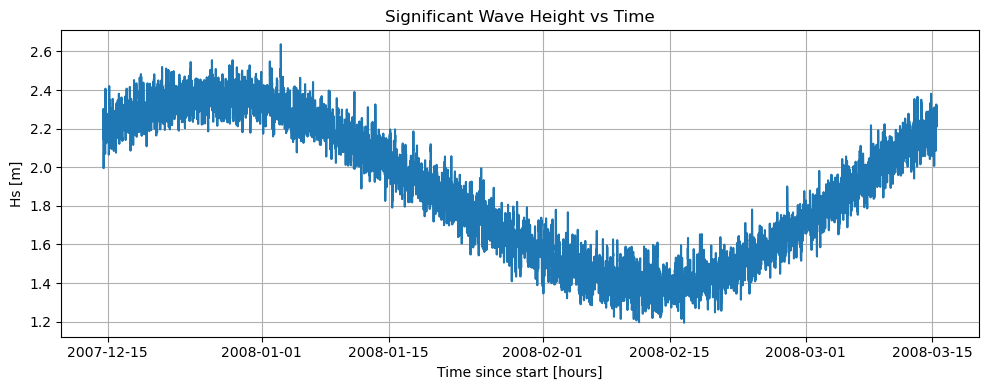

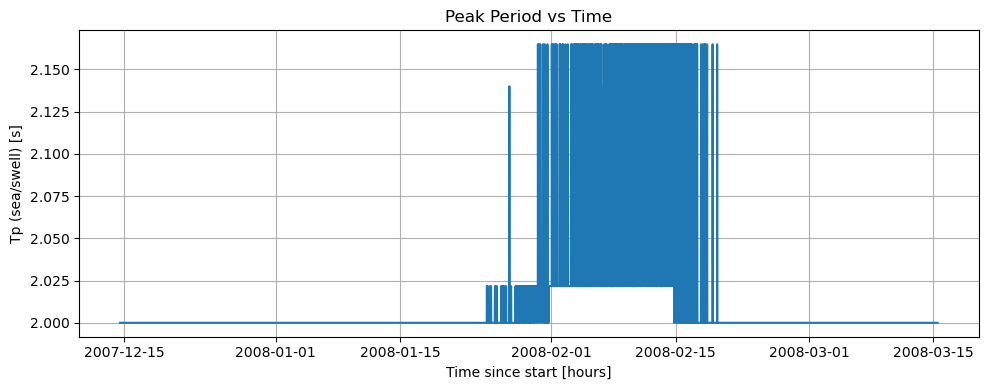

In [106]:
plt.figure(figsize=(10,4))
plt.plot(t_plot, Hs_ss)
plt.xlabel('Time since start [hours]')
plt.ylabel('Hs [m]')
plt.title('Significant Wave Height vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t_plot, Tp_ss)
plt.xlabel('Time since start [hours]')
plt.ylabel('Tp (sea/swell) [s]')
plt.title('Peak Period vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

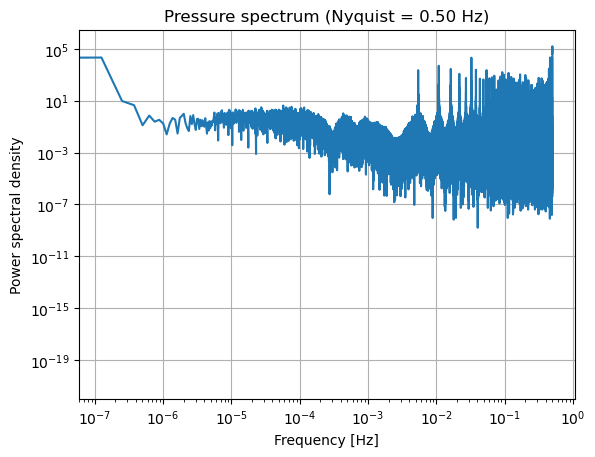

In [40]:
# Plot
plt.loglog(freqs, S)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density')
plt.title(f'Pressure spectrum (Nyquist = {fn:.2f} Hz)')
plt.grid(True)
plt.show()

(7948780,)

In [ ]:
1/0.w

2.0

In [ ]:

    # --- FFT and frequencies (two-sided), select band on |f|
    Xf = np.fft.fftshift(np.fft.fft(Xd, axis=0), axes=0)
    f  = np.fft.fftshift(np.fft.fftfreq(N, d=dt))  # Hz
    band_mask = (np.abs(f) >= fmin) & (np.abs(f) <= fmax)

    if not np.any(band_mask):
        raise ValueError("No frequency bins fall within [fmin, fmax]. Check dt/N.")

    # --- Hs for the band: H = 4 * sqrt( 1/((N-1)N) * sum_{band} |X|^2 )
    S = np.sum(np.abs(Xf[band_mask, :])**2, axis=0)
    scale = 1.0 / ((N - 1) * N)
    Hs = 4.0 * np.sqrt(scale * S)

    return float(Hs) if one_d else Hs


In [24]:
import numpy as np

def hs_band_timeseries(x, dt, fmin, fmax, win_len, step_len, dtrd=0, use_hann=True):
    """
    Time-varying significant wave height Hs over a band [fmin,fmax] (Hz),
    computed in sliding windows.

    Parameters
    ----------
    x : (N,) or (N,M) array
        Pressure/eta time series.
    dt : float
        Sample period [s].
    fmin, fmax : float
        Frequency band in Hz (inclusive on |f|).
    win_len : int
        Window length in samples (e.g., 1800 for 30 min at 1 Hz).
    step_len : int
        Hop size in samples between windows (e.g., 300 for 5 min step).
    dtrd : int
        Detrend degree: >0 polynomial of that degree; <=0 remove mean.
    use_hann : bool
        Apply Hann taper to each window (reduces leakage).

    Returns
    -------
    hs : (W,) or (W,M) array
        Hs for each window (W windows).
    twin : (W,) array
        Center time (seconds since start) for each window.
    """
    x = np.asarray(x, float)
    one_d = (x.ndim == 1)
    X = x[:, None] if one_d else x  # (N,M)

    N = X.shape[0]
    K = 1 if one_d else X.shape[1]

    # set up windows
    starts = np.arange(0, N - win_len + 1, step_len, dtype=int)
    W = len(starts)
    if W == 0:
        raise ValueError("win_len larger than series length.")

    # window taper
    if use_hann:
        w = np.hanning(win_len)[:, None]  # (win_len,1)
        # energy-correct scaling so Parseval holds approximately with taper
        w_norm = np.sqrt((win_len / np.sum(w**2)))
        w *= w_norm
    else:
        w = 1.0

    # frequency vector for this window length
    f = np.fft.fftshift(np.fft.fftfreq(win_len, d=dt))  # (win_len,)
    band_mask = (np.abs(f) >= fmin) & (np.abs(f) <= fmax)
    if not np.any(band_mask):
        raise ValueError("Band has no FFT bins for given win_len and dt.")

    hs = np.empty((W, K), float)
    t_centers = (starts + win_len / 2.0) * dt  # seconds since start

    t = np.arange(win_len) * dt

    for i, s in enumerate(starts):
        seg = X[s:s+win_len, :]  # (win_len, K)

        # detrend by your rule
        if dtrd > 0:
            Xd = np.empty_like(seg)
            for k in range(K):
                p = np.polyfit(t, seg[:, k], dtrd)
                trend = np.polyval(p, t)
                Xd[:, k] = seg[:, k] - trend
        else:
            Xd = seg - np.nanmean(seg, axis=0, keepdims=True)

        # taper
        Xd = Xd * w

        # FFT (time axis 0) -> shift
        Xf = np.fft.fftshift(np.fft.fft(Xd, axis=0), axes=0)

        # band energy and Hs with your scaling
        S = np.sum(np.abs(Xf[band_mask, :])**2, axis=0)
        scale = 1.0 / ((win_len - 1) * win_len)
        hs[i, :] = 4.0 * np.sqrt(scale * S)

    if one_d:
        return hs[:, 0], t_centers
    return hs, t_centers


In [107]:
"""
End-to-end spectral processing for Mokuleia deployment A, sensor 1.

The script reproduces the wave bulk parameters shown in PILOTmokuleia.pdf
using the pressure record stored in MoA18411.mat.  It

1. loads the raw 12 h bursts and inserts the 20 s download gaps,
2. converts pressure from psi to gauge Pascals and then to water depth,
3. removes the low-frequency tide with a moving mean,
4. interpolates across the short gaps, and
5. computes sliding spectra of surface elevation along with bulk metrics.

Figures are written to mokuleia/figures/.
"""
from __future__ import annotations

import math
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Iterable

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

# physical constants
PSI_TO_PA = 6894.757293168  # [Pa/psi]
RHO_SEAWATER = 1025.0  # [kg/m^3]
G = 9.80665  # [m/s^2]


@dataclass
class SensorSeries:
    """Container for the cleaned 1 Hz time series."""

    time: np.ndarray  # datetime64[ns]
    seconds: np.ndarray  # seconds since start, float64
    pressure_pa: np.ndarray  # gauge pressure, Pa
    depth_m: np.ndarray  # instantaneous water depth, m
    pressure_hp: np.ndarray  # high-passed pressure, Pa
    depth_lp: np.ndarray  # low-passed depth (tide), m


@dataclass
class SpectralSummary:
    """Sliding spectral diagnostics for quick plotting."""

    freqs: np.ndarray
    surface_spectra: np.ndarray  # shape (n_windows, n_freqs)
    time_centers: np.ndarray  # datetime64[ns]
    hs_total: np.ndarray
    hs_sea_swell: np.ndarray
    hs_infragravity: np.ndarray
    tp_sea_swell: np.ndarray


def matlab_datenum_to_datetime64(tnums: np.ndarray) -> np.ndarray:
    """Convert MATLAB datenum to numpy datetime64[ns]."""
    tnums = np.asarray(tnums, dtype=np.float64)
    days_since_unix = tnums - 719529.0
    ns_since_unix = np.round(days_since_unix * 86400.0 * 1e9).astype("int64")
    return np.datetime64("1970-01-01T00:00:00") + ns_since_unix.astype("timedelta64[ns]")


def moving_average_nan(x: np.ndarray, window: int) -> np.ndarray:
    """Centered moving average that ignores NaNs."""
    if window < 1:
        raise ValueError("window must be >= 1")
    x = np.asarray(x, dtype=np.float64)
    kernel = np.ones(window, dtype=np.float64)
    valid = np.isfinite(x).astype(np.float64)
    filled = np.where(np.isfinite(x), x, 0.0)
    num = np.convolve(filled, kernel, mode="same")
    den = np.convolve(valid, kernel, mode="same")
    out = np.full_like(x, np.nan)
    ok = den > 0
    out[ok] = num[ok] / den[ok]
    return out


def nan_interp(x: np.ndarray) -> np.ndarray:
    """Interpolate across NaNs using first-order hold."""
    x = np.asarray(x, dtype=np.float64)
    out = x.copy()
    isnan = ~np.isfinite(out)
    if not np.any(isnan):
        return out
    idx = np.arange(out.size)
    valid = ~isnan
    if not np.any(valid):
        raise ValueError("cannot interpolate array of all NaNs")
    out[isnan] = np.interp(idx[isnan], idx[valid], out[valid])
    return out


def wavenumber(omega: np.ndarray, depth: float, tol: float = 1e-12, max_iter: int = 64) -> np.ndarray:
    """Solve the linear dispersion relation for k(ω)."""
    omega = np.asarray(omega, dtype=np.float64)
    depth = float(depth)
    k = np.zeros_like(omega)
    if depth <= 0.0:
        return k
    mask = omega > 0.0
    if not np.any(mask):
        return k
    k_mask = (omega[mask] ** 2) / G  # deep-water guess
    for _ in range(max_iter):
        kh = k_mask * depth
        tanh_kh = np.tanh(kh)
        cosh_kh = np.cosh(kh)
        sech_kh_sq = 1.0 / (cosh_kh ** 2)
        f = G * k_mask * tanh_kh - omega[mask] ** 2
        df = G * tanh_kh + G * depth * k_mask * sech_kh_sq
        step = np.divide(f, df, out=np.zeros_like(f), where=df != 0.0)
        k_next = k_mask - step
        if np.nanmax(np.abs(step)) < tol:
            break
        k_mask = np.where(np.isfinite(k_next), k_next, k_mask)
    k[mask] = k_mask
    return k


def load_sensor_series(mat_path: Path, patm_psi: float = 14.7, tide_window: int = 3600, wave_window: int = 600) -> SensorSeries:
    """
    Load the 12 h bursts, insert 20 s download gaps, and derive helper series.

    Parameters
    ----------
    mat_path : Path
        Location of MoA18411.mat.
    patm_psi : float
        Atmospheric pressure used to convert absolute to gauge pressure (psi).
    tide_window : int
        Samples for the low-pass (tide) moving mean. Defaults to 1 h.
    wave_window : int
        Samples for the high-pass (wave) moving mean. Defaults to 10 min.
    """
    data = loadmat(mat_path)
    if "pclip" not in data or "tclip" not in data:
        raise KeyError("MAT file must contain 'pclip' and 'tclip'")
    pclip = np.asarray(data["pclip"], dtype=np.float64)
    tclip = np.asarray(data["tclip"], dtype=np.float64)
    if pclip.shape != tclip.shape:
        raise ValueError("pclip and tclip must share the same shape")

    nsamp, nburst = pclip.shape
    gap = 20  # samples
    block_len = nsamp + gap

    # convert to gauge Pascals and add NaN-filled gap
    pgauge_psi = pclip - patm_psi
    pgauge_pa = pgauge_psi * PSI_TO_PA
    stacked = np.full((block_len, nburst), np.nan)
    stacked[:nsamp, :] = pgauge_pa
    pressure_pa = stacked.reshape(-1, order="F")[:-gap]

    # water depth inferred from hydrostatic balance
    depth_stack = np.full((block_len, nburst), np.nan)
    depth_stack[:nsamp, :] = pgauge_pa / (RHO_SEAWATER * G)
    depth_m = depth_stack.reshape(-1, order="F")[:-gap]

    # build continuous time vector (1 Hz sampling)
    dt_seconds = 1.0
    n_total = pressure_pa.size
    time_seconds = np.arange(n_total, dtype=np.float64) * dt_seconds
    time_days = tclip[0, 0] + time_seconds / 86400.0
    time = matlab_datenum_to_datetime64(time_days)

    # slow-varying tide (ignore NaNs) and high-pass pressure component
    depth_lp = moving_average_nan(depth_m, tide_window)
    pressure_trend = moving_average_nan(pressure_pa, wave_window)
    pressure_hp = pressure_pa - pressure_trend

    return SensorSeries(
        time=time,
        seconds=time_seconds,
        pressure_pa=pressure_pa,
        depth_m=depth_m,
        pressure_hp=pressure_hp,
        depth_lp=depth_lp,
    )


def compute_sliding_spectra(series: SensorSeries, win_len: int = 2048, step: int = 512) -> SpectralSummary:
    """Welch-like spectral analysis in sliding windows."""
    p_hp = nan_interp(series.pressure_hp)
    depth_lp = nan_interp(series.depth_lp)
    n = p_hp.size
    if n < win_len:
        raise ValueError("time series shorter than window length")
    starts = np.arange(0, n - win_len + 1, step, dtype=int)
    hann = np.hanning(win_len)
    hann *= math.sqrt(win_len / np.sum(hann ** 2))  # energy conserving

    freqs = np.fft.rfftfreq(win_len, d=1.0)
    omega = 2.0 * np.pi * freqs

    spectra = []
    hs_total = []
    hs_ss = []
    hs_ig = []
    tp_ss = []
    t_mid = []

    mask_total = freqs > 0.0
    mask_ss = (freqs >= 0.05) & (freqs <= 0.33)
    mask_ig = (freqs >= 0.004) & (freqs <= 0.04)

    for start in starts:
        stop = start + win_len
        seg = p_hp[start:stop]
        depth_seg = depth_lp[start:stop]
        if np.any(~np.isfinite(seg)):
            continue
        seg = seg - np.mean(seg)
        seg *= hann
        fft_vals = np.fft.rfft(seg)

        # one-sided PSD of pressure (Pa^2/Hz)
        scale = (1.0 / win_len) ** 2
        Spp = (2.0 * scale) * (np.abs(fft_vals) ** 2)
        Spp[0] = scale * (np.abs(fft_vals[0]) ** 2)
        if win_len % 2 == 0:
            Spp[-1] = scale * (np.abs(fft_vals[-1]) ** 2)
        Spp *= 1.0  # dt = 1 s already accounted for

        h_eff = float(np.nanmean(depth_seg))
        k = wavenumber(omega, h_eff)
        transfer = np.cosh(k * h_eff) / (RHO_SEAWATER * G)
        Seta = (transfer ** 2) * Spp
        spectra.append(Seta)

        def m0(mask: np.ndarray) -> float:
            if not np.any(mask):
                return 0.0
            return float(np.trapz(Seta[mask], freqs[mask]))

        m0_total = m0(mask_total)
        m0_ss = m0(mask_ss)
        m0_ig = m0(mask_ig)

        hs_total.append(4.0 * math.sqrt(max(m0_total, 0.0)))
        hs_ss.append(4.0 * math.sqrt(max(m0_ss, 0.0)))
        hs_ig.append(4.0 * math.sqrt(max(m0_ig, 0.0)))

        if np.any(mask_ss):
            ss_spec = Seta[mask_ss]
            if np.all(np.isfinite(ss_spec)) and np.nanmax(ss_spec) > 0.0:
                fp = freqs[mask_ss][np.nanargmax(ss_spec)]
                tp_ss.append(1.0 / fp if fp > 0.0 else np.nan)
            else:
                tp_ss.append(np.nan)
        else:
            tp_ss.append(np.nan)

        t_idx = start + win_len // 2
        t_mid.append(series.time[t_idx])

    if not spectra:
        raise RuntimeError("no valid segments found for spectral analysis")

    return SpectralSummary(
        freqs=freqs,
        surface_spectra=np.vstack(spectra),
        time_centers=np.array(t_mid),
        hs_total=np.array(hs_total),
        hs_sea_swell=np.array(hs_ss),
        hs_infragravity=np.array(hs_ig),
        tp_sea_swell=np.array(tp_ss),
    )


def to_datetime(objects: Iterable[np.datetime64]) -> list[datetime]:
    """Convert numpy datetime64 array to Python datetime list for plotting."""
    arr = np.asarray(list(objects), dtype="datetime64[ns]")
    return arr.astype("datetime64[ms]").astype(object).tolist()


def plot_results(series: SensorSeries, summary: SpectralSummary, out_dir: Path) -> None:
    """Create figures similar to PILOTmokuleia sensor summaries."""
    out_dir.mkdir(parents=True, exist_ok=True)

    # Hs time series
    time_mid = to_datetime(summary.time_centers)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(time_mid, summary.hs_total, label="Hs (total)")
    ax.plot(time_mid, summary.hs_sea_swell, label="Hs (sea/swell)")
    ax.plot(time_mid, summary.hs_infragravity, label="Hs (IG)")
    ax.set_ylabel("Significant wave height [m]")
    ax.set_xlabel("Time")
    ax.set_title("Sensor 1 significant wave height")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    fig.tight_layout()
    fig.savefig(out_dir / "sensor1_hs_timeseries.png", dpi=200)
    plt.close(fig)

    # peak period
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(time_mid, summary.tp_sea_swell, color="#d95f02")
    ax.set_ylabel("Tp (sea/swell) [s]")
    ax.set_xlabel("Time")
    ax.set_title("Sea/swell peak period")
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    fig.tight_layout()
    fig.savefig(out_dir / "sensor1_tp_timeseries.png", dpi=200)
    plt.close(fig)

    # representative spectrum (median over time)
    S_eta_median = np.nanmedian(summary.surface_spectra, axis=0)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.loglog(summary.freqs[1:], S_eta_median[1:], lw=1.8)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Surface elevation spectrum [m^2/Hz]")
    ax.set_title("Median surface elevation spectrum (sensor 1)")
    ax.grid(True, which="both", alpha=0.3)
    fig.tight_layout()
    fig.savefig(out_dir / "sensor1_median_spectrum.png", dpi=200)
    plt.close(fig)

    # raw gauge pressure vs time for context
    time_all = to_datetime(series.time)
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(time_all, series.pressure_pa / (RHO_SEAWATER * G), color="#1b9e77", lw=0.6)
    ax.set_ylabel("Water depth [m]")
    ax.set_xlabel("Time")
    ax.set_title("Sensor 1 hydrostatic water depth")
    ax.grid(True, alpha=0.2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    fig.tight_layout()
    fig.savefig(out_dir / "sensor1_depth_series.png", dpi=200)
    plt.close(fig)


def main() -> None:
    base_dir = Path(__file__).resolve().parent
    mat_path = base_dir / "MoA18411.mat"
    series = load_sensor_series(mat_path)
    summary = compute_sliding_spectra(series)
    plot_results(series, summary, base_dir / "figures")


if __name__ == "__main__":
    main()


NameError: name '__file__' is not defined